# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


# Download Dataset

In [3]:
file={"username":"mojtabanafez","key":"7c0ebd541704e0cb4357c05f78ed5fa2"}
import json
with open('kaggle.json', 'w') as fp:
    json.dump(file, fp)
! pip install kaggle -q
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder -q
!unzip -q /content/stanford-car-dataset-by-classes-folder.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists


# Create Generator

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

TRAIN_DATA_PATH = "./car_data/car_data/train"
TEST_DATA_PATH = "./car_data/car_data/test"

TRANSFORM_IMG_test =  transforms.Compose(
    [
      transforms.ToTensor(), 
      transforms.Resize(size=(224,224)),
     ])

TRANSFORM_IMG_train =  transforms.Compose(
    [
      transforms.ToTensor(), 
      transforms.RandomRotation(30),
      transforms.RandomHorizontalFlip(),
      transforms.Resize(size=(224,224)),
     ])
BATCH_SIZE=32
batch_size_1 = 10
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG_train)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG_test)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 


In [5]:
len(train_data_loader), len(test_data_loader)

(255, 252)

In [6]:
classes = list(train_data.class_to_idx)
dl=iter(train_data_loader)
x, y= next(dl)
x.shape, y.shape, torch.mean(x), torch.min(x), torch.max(x)

(torch.Size([32, 3, 224, 224]),
 torch.Size([32]),
 tensor(0.3981),
 tensor(0.),
 tensor(1.))

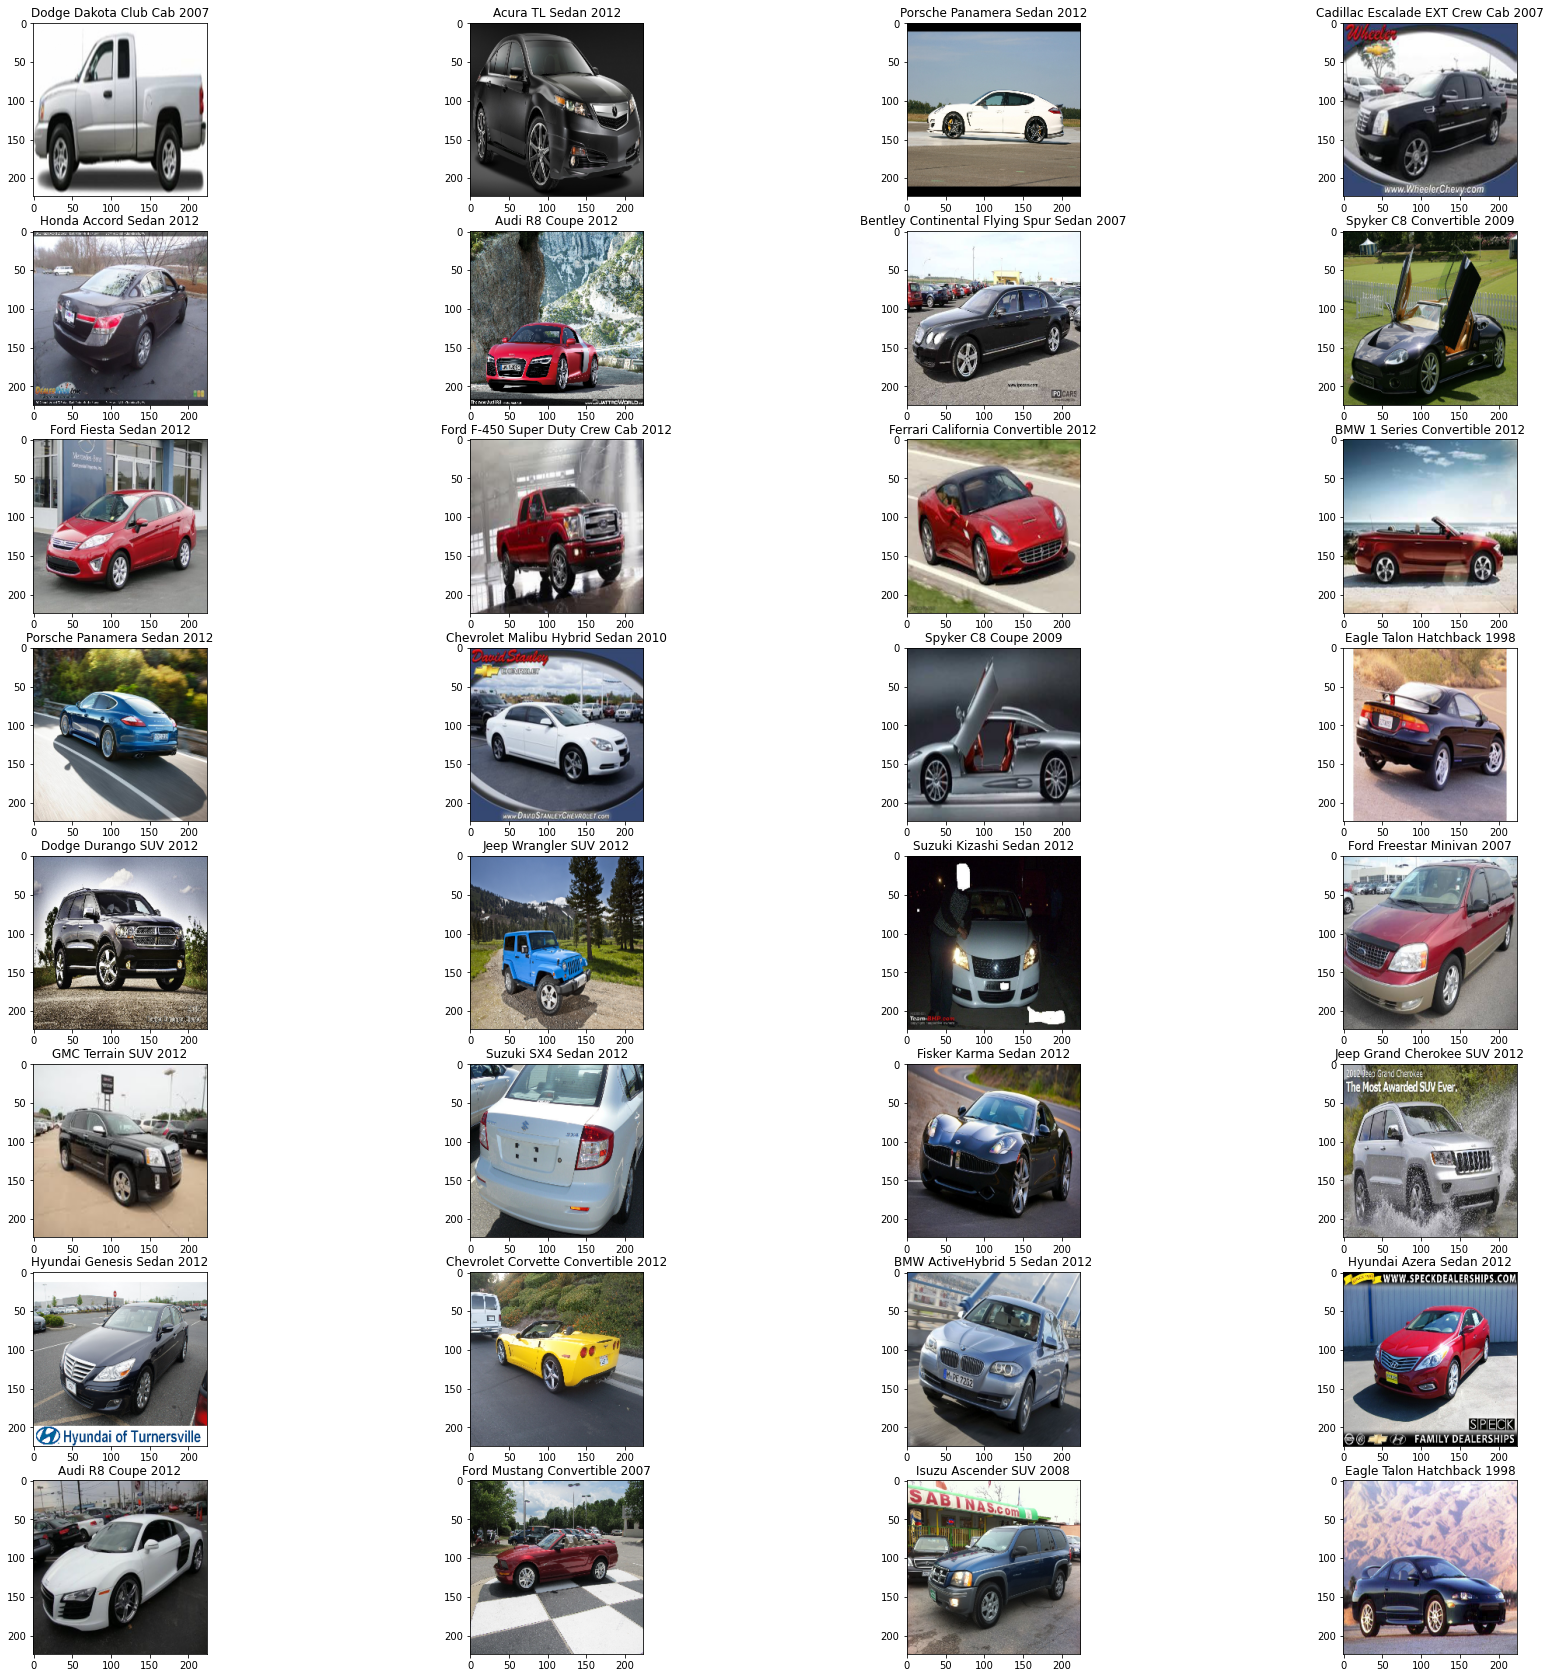

In [7]:
import numpy as np

test_loader=iter(test_data_loader)
image, labels = test_loader.next()
image=np.array(image)
nrows=8
ncols=4
plt.figure (figsize = (30, 30))
image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 1, 2))
for i in range(image.shape[0]):
    sp = plt.subplot(nrows, ncols, i+1)
    plt.imshow(image[i])
    plt.title(classes[int(labels[i])])
plt.show()
# print(image.shape, np.mean(image), np.max(image), np.min(image))

In [10]:
dataloaders={
    'train':train_data_loader,
    'val': test_data_loader
}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}

def save_checkpoint (state, filename):
    """ saving model's weights """
    print ('=> saving checkpoint')
    torch.save (state, filename)


def load_checkpoint (checkpoint, model):
    """ loading model's weights """
    print ('=> loading checkpoint')
    model.load_state_dict (checkpoint ['state_dict'])


def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')
            data_size=0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = torch.squeeze(outputs)
                    preds = (outputs > 0.5).float ()
                    loss = criterion(outputs.float(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                data_size+=len(outputs)

                current_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(preds, dim=-1)
                current_corrects += torch.sum(preds == labels.data)            


            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / data_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                  
        # saving models weights
        if epoch % 5 == 0:
          checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
          save_checkpoint(checkpoint, f'/content/checkpoint_{epoch}.pth')

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model
dataset_sizes

{'train': 255, 'val': 252}

In [11]:
class ResnetModel(nn.Module):
    def __init__(self, original_model, num_classes, classifier= None):
        super(ResnetModel, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        if classifier == None:
          print('default classifier ...')
          self.classifier = nn.Sequential(
              nn.Linear(2048, num_classes),
          )
        else:
          print('built classifier ...')
          self.classifier = classifier

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

# first part

In [ ]:
# Create Res-Net model with ranom weights
res_mod_rand_weights = models.resnet50(pretrained=False)
model_rand_weights = ResnetModel(res_mod_rand_weights, num_classes=len(classes))
pytorch_total_params = sum(p.numel() for p in model_rand_weights.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model_rand_weights.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)
model_rand_weights

pytorch_total_params=  23909636
pytorch_total_trainable_params=  23909636


ResnetModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_rand_weights = model_rand_weights.to(device)
criterion = nn.CrossEntropyLoss() 

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_rand_weights.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
base_model = train_model(model_rand_weights, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)


Epoch 0/9
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 173.1978 Acc: 0.0052
Iterating through data...
val Loss: 168.6021 Acc: 0.0096
=> saving checkpoint

Epoch 1/9
----------
Iterating through data...
train Loss: 166.6883 Acc: 0.0068
Iterating through data...
val Loss: 165.8531 Acc: 0.0087
=> saving checkpoint

Epoch 2/9
----------
Iterating through data...
train Loss: 165.4383 Acc: 0.0075
Iterating through data...
val Loss: 164.2116 Acc: 0.0080
=> saving checkpoint

Epoch 3/9
----------
Iterating through data...
train Loss: 164.1454 Acc: 0.0076
Iterating through data...
val Loss: 164.1786 Acc: 0.0083
=> saving checkpoint

Epoch 4/9
----------
Iterating through data...
train Loss: 162.4995 Acc: 0.0113
Iterating through data...
val Loss: 164.1874 Acc: 0.0083
=> saving checkpoint

Epoch 5/9
----------
Iterating through data...
train Loss: 161.3835 Acc: 0.0120
Iterating through data...
val Loss: 160.3678 Acc: 0.0131
=> saving checkpoint

Epoch 6/9
----------
Iterating through data...
train Loss: 157.7460 Acc: 0.0136
Iterating thr

In [ ]:
### continue learning from epoch=10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get checkpoint from Drive
checkpoint = torch.load('/content/drive/MyDrive/checkpoint_9.pth')

# definition our model
res_mod_rand_weights = models.resnet50(pretrained=False)
model_rand_weights = ResnetModel(res_mod_rand_weights, num_classes=len(classes))
model_rand_weights.load_state_dict(checkpoint['state_dict'])
model_rand_weights = model_rand_weights.to(device)

# upload state_dict
optimizer_ft = optim.Adam(model_rand_weights.parameters(), lr=0.001)
optimizer_ft.load_state_dict(checkpoint['optimizer'])

criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
base_model = train_model(model_rand_weights, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)


Epoch 0/9
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 150.8050 Acc: 0.0210
Iterating through data...
val Loss: 154.1891 Acc: 0.0189
=> saving checkpoint

Epoch 1/9
----------
Iterating through data...
train Loss: 149.1383 Acc: 0.0233
Iterating through data...
val Loss: 151.0892 Acc: 0.0199

Epoch 2/9
----------
Iterating through data...
train Loss: 147.2519 Acc: 0.0263
Iterating through data...
val Loss: 148.7667 Acc: 0.0228

Epoch 3/9
----------
Iterating through data...
train Loss: 145.2484 Acc: 0.0293
Iterating through data...
val Loss: 146.8791 Acc: 0.0260
=> saving checkpoint

Epoch 4/9
----------
Iterating through data...
train Loss: 142.7569 Acc: 0.0329
Iterating through data...
val Loss: 150.1897 Acc: 0.0235

Epoch 5/9
----------
Iterating through data...
train Loss: 140.2291 Acc: 0.0350
Iterating through data...
val Loss: 144.3288 Acc: 0.0306

Epoch 6/9
----------
Iterating through data...
train Loss: 135.6640 Acc: 0.0431
Iterating through data...
val Loss: 141.6564 Acc: 0.0308
=> saving checkpoint

Epoch 7/9
--------

# second part

In [ ]:
def train_model_pytorch(model, criterion, optimizer, sched, num_epochs=5, device='cuda'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    start = time.time()
    train_results = []
    valid_results = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':            
              model.train()  # Set model to training mode
            else:
              model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # sched.step()
                        loss.backward()
                        
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            if(phase == 'train'):
              train_results.append([epoch_loss,epoch_acc])
            if(phase == 'val'):
              valid_results.append([epoch_loss,epoch_acc])
                                   
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model (Early Stopping) and Saving our model, when we get best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())      
                model_save_name = "resnetCars_fine_tune.pth"
                path = F"/content/drive/MyDrive/{model_save_name}"
                checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
                torch.save(checkpoint, path)
                print ('=> saving checkpoint ...')


        print()

    # Calculating time it took for model to train    
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    
    return model,train_results,valid_results

In [ ]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False
        
def build_classifier(input_features_num, out_features_num, hidden_layers_num=None):
  classifier = nn.Sequential()
  classifier.add_module('fc0', nn.Linear(in_features=input_features_num, out_features= 1024))
  classifier.add_module('relu0', nn.ReLU())
  classifier.add_module('output', nn.Linear(in_features=1024, out_features=out_features_num))
  return classifier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_resnet_model = models.resnet50(pretrained=True)
all_params_without_classifier = sum(1 for p in base_resnet_model.parameters())
trainable_params_before_freeze = len([p for p in base_resnet_model.parameters() if p.requires_grad == True ])
set_parameter_requires_grad(base_resnet_model)


print(f'The Input Of Last Layer in ResNet50 has : {base_resnet_model.fc.in_features} neurons')
print(f'The Output Of Last Layer in ResNet50  has : {base_resnet_model.fc.out_features} neurons')
print()


classifier_b = build_classifier(input_features_num = base_resnet_model.fc.in_features, out_features_num= 196)
base_resnet_model = ResnetModel(base_resnet_model, num_classes=len(classes), classifier=classifier_b)
all_params_with_classifier = sum(1 for p in base_resnet_model.parameters())
trainable_params_after_freeze = len([p for p in base_resnet_model.parameters() if p.requires_grad == True ])

print(f'all_params_WITHOUT_classifier : {all_params_without_classifier}')
print(f'trainable_params_BEFORE_freeze : {trainable_params_before_freeze}')
print('=='*20)
print(f'all_params_WITH_classifier : {all_params_with_classifier}')
print(f'trainable_params_AFTER_freeze : {trainable_params_after_freeze}')

The Input Of Last Layer in ResNet50 has : 2048 neurons
The Output Of Last Layer in ResNet50  has : 1000 neurons

built classifier ...
all_params_WITHOUT_classifier : 161
trainable_params_BEFORE_freeze : 161
all_params_WITH_classifier : 163
trainable_params_AFTER_freeze : 4


In [ ]:
# trian the model

base_resnet_model = base_resnet_model.to(device)

# segment learnable params
params_to_update = []
for name, param in base_resnet_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# definition of optimizer
optimizer_ft1 = optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='max', patience=3, threshold = 0.9)
base_trained_model = train_model_pytorch(base_resnet_model, criterion, optimizer_ft1, exp_lr_scheduler, num_epochs=5)

Epoch 1/5
----------
train Loss: 5.2064 Acc: 0.0082
val Loss: 4.9020 Acc: 0.0194
=> saving checkpoint ...

Epoch 2/5
----------
train Loss: 4.7838 Acc: 0.0266
val Loss: 4.4915 Acc: 0.0418
=> saving checkpoint ...

Epoch 3/5
----------
train Loss: 4.5143 Acc: 0.0416
val Loss: 4.2788 Acc: 0.0589
=> saving checkpoint ...

Epoch 4/5
----------
train Loss: 4.3551 Acc: 0.0546
val Loss: 4.2371 Acc: 0.0613
=> saving checkpoint ...

Epoch 5/5
----------
train Loss: 4.2433 Acc: 0.0641
val Loss: 4.0484 Acc: 0.0801
=> saving checkpoint ...

Training complete in 43m 27s
Best val Acc: 0.080090


# third part

In [ ]:
def feature_extraction(model, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    start = time.time()
    feature = []
    target = []
    step = False
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        running_corrects = 0

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            classifier_input = outputs.to('cpu').detach().numpy()
            classifier_target = labels.to('cpu').detach().numpy()
            if step:
                preds = svm_model.predict(classifier_input)
                running_corrects += np.sum(preds == classifier_target)
            svm_model.fit(classifier_input, classifier_target)
            step = True
        epoch_acc = running_corrects / dataset_sizes['train']                                   
        print('{} Acc: {:.4f}'.format('train', 0, epoch_acc))

        print()
    time_elapsed = time.time() - start
    print('Extracting complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return feature, target    

In [ ]:
from sklearn.svm import SVC
from joblib import dump, load
num_in_features = 2048
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet_model =  models.resnet50(pretrained=True)
resnet_model.to(device)
svm_model = SVC(kernel = 'poly', C = 1)

for param in resnet_model.parameters():
  param.require_grad = False

features, targets = feature_extraction(resnet_model, 10)

Epoch 1/10
----------
train Loss: 0.0000 Acc: 0.1725

Epoch 2/10
----------
train Loss: 0.0000 Acc: 0.1922

Epoch 3/10
----------
train Loss: 0.0000 Acc: 0.1922

Epoch 4/10
----------
train Loss: 0.0000 Acc: 0.1843

Epoch 5/10
----------
train Loss: 0.0000 Acc: 0.1451

Epoch 6/10
----------
train Loss: 0.0000 Acc: 0.2235

Epoch 7/10
----------
train Loss: 0.0000 Acc: 0.1647

Epoch 8/10
----------
train Loss: 0.0000 Acc: 0.1725

Epoch 9/10
----------
train Loss: 0.0000 Acc: 0.1490

Epoch 10/10
----------
train Loss: 0.0000 Acc: 0.1490

Extracting complete in 62m 57s


# fourth part


In [ ]:
def get_model(path):
  checkpoint = torch.load(path)
  base_model = models.resnet50(pretrained=True)
  fine_tune(base_model)
  classifier_b = build_classifier(input_features_num = base_model.fc.in_features, out_features_num= 196)
  base_model = ResnetModel(base_model, num_classes=len(classes), classifier=classifier_b)
  base_model.load_state_dict(checkpoint['state_dict'])
  trainable_params = len([p for p in base_model.parameters() if p.requires_grad == True ])
  print(f'trainable_params : {trainable_params}')
  print()
  return base_model


In [ ]:
def fine_tune(model):
    for param in model.parameters():
        param.requires_grad = True
    return model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = get_model('/content/drive/MyDrive/resnetCars.pth')
resnet_model.to(device)
optimizer_ft2 = optim.Adam(resnet_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='max', patience=3, threshold = 0.9)

base_trained_model_fine_tune = train_model_pytorch(resnet_model, criterion, optimizer_ft2, exp_lr_scheduler, num_epochs=5)

built classifier ...
trainable_params : 163

Epoch 1/5
----------
train Loss: 4.5687 Acc: 0.0435
val Loss: 4.1340 Acc: 0.0654
=> saving checkpoint ...

Epoch 2/5
----------
train Loss: 3.9003 Acc: 0.0911
val Loss: 4.0192 Acc: 0.0737
=> saving checkpoint ...

Epoch 3/5
----------
train Loss: 3.5714 Acc: 0.1240
val Loss: 3.5490 Acc: 0.1429
=> saving checkpoint ...

Epoch 4/5
----------
train Loss: 3.2155 Acc: 0.1670
val Loss: 3.6129 Acc: 0.1434
=> saving checkpoint ...

Epoch 5/5
----------
train Loss: 3.0019 Acc: 0.2052
val Loss: 3.1011 Acc: 0.1957
=> saving checkpoint ...

Training complete in 47m 28s
Best val Acc: 0.195747


# fifth part


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path_before_fine_tune = '/content/drive/MyDrive/resnetCars.pth'
path_after_fine_tune = '/content/drive/MyDrive/resnetCars_fine_tune.pth'

data_itr = iter(train_data_loader)
X, y= next(data_itr)
X = X.to(device)

sample = X[0]
shape = (1, 3, 224, 224)
sample = sample.reshape(shape)

shape

(1, 3, 224, 224)